# Entraînement du modèle d'IA
Ce notebook est entièrement dédié à l'entraînement du modèle de reconnaissance d'entités. Il se base sur le modèle *camembert-base*, qui est une version finetunée pour la langue française du modèle de fondation *RoBERTa*, créé par Facebook. Notre objectif est de spécialiser le modèle *camembert-base* sur la tâche de reconnaissance d'entités par finetuning.

Pour ce faire, nous allons utiliser le jeu de données <a href="https://metatext.io/datasets/wikiner">*wikiner_fr*</a>, qui est un dataset créé à partir d'articles Wikipédia qui ont été labellisé à la main à des fins d'apprentissage supervisés. Voyons dans un premier temps à quoi ressemble ce jeu de données.  

### Importation du jeu de données
##### Téléchargement depuis HuggingFace

In [1]:
from huggingface_hub import snapshot_download


snapshot_download(
    repo_id="Jean-Baptiste/wikiner_fr",
    repo_type='dataset',
    local_dir='.',
    allow_patterns='data/*'
)

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

'/Users/clement/Documents/IA_SCHOOL/projetia'

##### Importation des données dans un DataFrame

In [2]:
import pandas as pd


df = pd.concat([
    pd.read_parquet('data/train-00000-of-00001-8a0e6775bf277040.parquet'),
    pd.read_parquet('data/test-00000-of-00001-f042d39bd1dddf20.parquet')
])

df.head()

,id,tokens,ner_tags
0,28871,"[The, Shining, ou, Shining, ,, l', enfant, lum...","[0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, ..."
1,110859,"[Son, poste, offre, à, Bach, un, certain, conf...","[0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,65202,"[Aujourd'hui, ,, la, contestation, est, plus, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, ..."
3,63881,"[L', Organisation, internationale, de, la, fra...","[0, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 3, 3, 3, ..."
4,78077,"[Cependant, en, 1514, ,, Henri, quitta, l', al...","[0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


##### Traitements basiques du DataFrame
On retire la colonne `id`, inutile dans le contexte de l'entraînement d'un modèle :

In [3]:
df = df.drop(columns='id')
df.head()

,tokens,ner_tags
0,"[The, Shining, ou, Shining, ,, l', enfant, lum...","[0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, ..."
1,"[Son, poste, offre, à, Bach, un, certain, conf...","[0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[Aujourd'hui, ,, la, contestation, est, plus, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, ..."
3,"[L', Organisation, internationale, de, la, fra...","[0, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 3, 3, 3, ..."
4,"[Cependant, en, 1514, ,, Henri, quitta, l', al...","[0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Ainsi, le dataset présente 2 colonnes :
- La première colonne représente le contenu de chaque article *Wikipedia*, prédécoupé sous forme de tokens contenus dans une liste.
- La seconde colonne représente, pour chaque token des listes de la première colonne, le type d'entité associé. Chaque type d'entité est encodé comme suit :

In [4]:
ID2LABEL = {
    0: 'O',         # Ce n'est pas une entité
    1: 'LOC',       # Localités
    2: 'PER',       # Identités
    3: 'MISC',      # Autres entités
    4: 'ORG'        # Organisations
}
LABEL2ID = {value: key for key, value in ID2LABEL.items()}

Concernant ces deux colonnes, on doit s'assurer que tous les éléments sont de type `list` pour que le fonctionnement du modèle ne soit pas impacté : 

In [5]:
df['tokens'] = df['tokens'].apply(list)
df['ner_tags'] = df['ner_tags'].apply(list)

Enfin, pour éviter toute confusion vis-à-vis des prochaines étapes de tokenisation, nous allons renommer la première colonne :

In [6]:
df = df.rename(columns={'tokens': 'str_tokens'})
df.head()

,str_tokens,ner_tags
0,"[The, Shining, ou, Shining, ,, l', enfant, lum...","[0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, ..."
1,"[Son, poste, offre, à, Bach, un, certain, conf...","[0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[Aujourd'hui, ,, la, contestation, est, plus, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, ..."
3,"[L', Organisation, internationale, de, la, fra...","[0, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 3, 3, 3, ..."
4,"[Cependant, en, 1514, ,, Henri, quitta, l', al...","[0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


##### Tokenisation des mots
Dans le cadre d'un modèle de NLP, ce jeu de données est exploitable tel qu'il se présente. Le seul traitement à réaliser est la tokenisation de la première colonne, qui sera effectuée à travers l'opération suivante :

In [7]:
from transformers import AutoTokenizer


# Tokenisation
tokenizer = AutoTokenizer.from_pretrained('camembert-base')
int_tokens = tokenizer(df['str_tokens'].tolist(), is_split_into_words=True, truncation=True, padding=True)

# Ajout des résultats au DataFrame
df['tokenizer_input_ids'] = int_tokens['input_ids']
df['tokenizer_attention_mask'] = int_tokens['attention_mask']
df = df[['str_tokens', 'tokenizer_input_ids', 'tokenizer_attention_mask', 'ner_tags']]

df.head()

,str_tokens,tokenizer_input_ids,tokenizer_attention_mask,ner_tags
0,"[The, Shining, ou, Shining, ,, l', enfant, lum...","[5, 908, 14823, 402, 47, 14823, 402, 21, 7, 17...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, ..."
1,"[Son, poste, offre, à, Bach, un, certain, conf...","[5, 685, 1337, 628, 15, 13977, 23, 1000, 1440,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[Aujourd'hui, ,, la, contestation, est, plus, ...","[5, 1301, 11, 265, 21, 7, 13, 13241, 30, 40, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, ..."
3,"[L', Organisation, internationale, de, la, fra...","[5, 71, 11, 13817, 1578, 8, 13, 26638, 14905, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 3, 3, 3, ..."
4,"[Cependant, en, 1514, ,, Henri, quitta, l', al...","[5, 1420, 22, 338, 2181, 21, 7, 4934, 17540, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


La tokenisation s'est effectuée correctement, toutefois on peut s'apercevoir que le nombre de tokens est plus élevé que le nombre de tags labellisé, en atteste les quelques résultats suivants qui représentent la longueur des listes pour chaque élément des colonnes `int_tokens` et `ner_tags` :

In [8]:
pd.concat(
    objs=[
        df['tokenizer_input_ids'].apply(lambda x: len(x)),
        df['ner_tags'].apply(lambda x: len(x))
    ],
    axis=1
).head()

,tokenizer_input_ids,ner_tags
0,356,22
1,356,19
2,356,50
3,356,41
4,356,18


Cela est dû au fait que certains mots sont parfois découpées en plusieurs parties lors de la tokenisation, il est donc nécessaire de procéder à un réalignement pour que listes des colonnes `tokens` et `ner_tags` soient de taille identique. Le réalignement s'effectue à l'échelle des tags, comme suit :

In [9]:
ner_tags = []

for i, tag in enumerate(df['ner_tags']):
    word_ids = int_tokens.word_ids(batch_index=i) 
    previous_word_idx = None
    label_ids = []
    
    for word_idx in word_ids:
        # Pour les tokens valant None, on attribue la valeur -100, qui sera négligeable
        # lors de l'utilisation de la fonction de perte
        if word_idx is None:
            label_ids.append(-100) 
            
        # Pour tous les autres tokens, on attribue la valeur du tag d'entité associé
        # au mot correspondant
        else:
            label_ids.append(tag[word_idx])
        
        previous_word_idx = word_idx

    ner_tags.append(label_ids)

On remplace alors les valeurs de la colonne `ner_tags` par les nouvelles valeurs réalignées : 

In [10]:
df['ner_tags'] = ner_tags
df.head()

,str_tokens,tokenizer_input_ids,tokenizer_attention_mask,ner_tags
0,"[The, Shining, ou, Shining, ,, l', enfant, lum...","[5, 908, 14823, 402, 47, 14823, 402, 21, 7, 17...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 3, 3, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[Son, poste, offre, à, Bach, un, certain, conf...","[5, 685, 1337, 628, 15, 13977, 23, 1000, 1440,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[Aujourd'hui, ,, la, contestation, est, plus, ...","[5, 1301, 11, 265, 21, 7, 13, 13241, 30, 40, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[L', Organisation, internationale, de, la, fra...","[5, 71, 11, 13817, 1578, 8, 13, 26638, 14905, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 0, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, ..."
4,"[Cependant, en, 1514, ,, Henri, quitta, l', al...","[5, 1420, 22, 338, 2181, 21, 7, 4934, 17540, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, ..."


On peut vérifier que le traitement a bien été effectué en regardant, pour les colonnes `int_tokens` et `ner_tags`, que les longueurs des listes sont toutes identiques :

In [11]:
pd.concat(
    objs=[
        df['tokenizer_input_ids'].apply(lambda x: len(x)),
        df['ner_tags'].apply(lambda x: len(x))
    ],
    axis=1
).head()

,tokenizer_input_ids,ner_tags
0,356,356
1,356,356
2,356,356
3,356,356
4,356,356


##### Mise en forme des données
Lors de l'entraînement, la bibliothèque *transformers* requiert que les données soient mises en forme d'une façon bien particulière. En l'occurence, c'est au travers de la classe suivante que nos données seront transmises au modèle :

In [12]:
import torch


class NERDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.input_ids = df['tokenizer_input_ids']
        self.attention_mask = df['tokenizer_attention_mask']
        self.labels = df['ner_tags']

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids.iloc[idx]),
            'attention_mask': torch.tensor(self.attention_mask.iloc[idx]),
            'labels': torch.tensor(self.labels.iloc[idx])
        }

    def __len__(self):
        return len(self.labels)

##### Séparation du jeu de données
Il ne reste désormais plus qu'à séparer le jeu de données en plusieurs sous-jeux de données, un dédié à l'entraînement, un autre dédié à l'évaluation, ainsi qu'un jeu de données dédié au test :

In [13]:
import numpy as np


train, val, test = np.split(
    df.sample(frac=1),
    [int(.7*len(df)), int(.8*len(df))]
)

train_dataset = NERDataset(train)
val_dataset = NERDataset(val)
test_dataset = NERDataset(test)

/Users/clement/Documents/IA_SCHOOL/projetia/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


### Entraînement du modèle
Comme dit plus tôt, le modèle à partir duquel nous allons créer notre NER est le modèle `camembert-base`. La première étape consiste à le télécharger et à l'importer. On vient également dès maintenant préciser quelles sont les différentes classes visibles dans le jeu de données.

In [14]:
from transformers import AutoModelForTokenClassification


model = AutoModelForTokenClassification.from_pretrained(
    pretrained_model_name_or_path='camembert-base',
    num_labels=len(ID2LABEL),
    id2label=ID2LABEL,
    label2id=LABEL2ID
)

Some weights of CamembertForTokenClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Par la suite, nous devons définir les modalités d'entraînement du modèle. Pour cela, nous allons utiliser la l'outil `TrainingArguments` :

In [15]:
from transformers import TrainingArguments


training_args = TrainingArguments(
    output_dir='./models/RoBERTa-ner',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True
)

On définit également un `DataCollator`, qui s'occupe de la mise en forme des données d'entrée, comme du padding :

In [16]:
from transformers import DataCollatorForTokenClassification


data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

Pour un modèle de NER, il est recommandé d'utiliser la métrique *seqeval*. Par ailleurs, nous définirons une fonction `compute_metrics` qui retourne les différents scores intéressants pour juger des performances du modèle :

In [17]:
import evaluate

import numpy as np


def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    results = evaluate.load('seqeval').compute(
        predictions=[
            [ID2LABEL[p] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
        ],
        references=[
            [ID2LABEL[l] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
        ]
    )

    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

Pour finir, on définit une instance de la classe `Trainer` à partir de laquelle l'entraînement se fera :

In [18]:
from transformers import Trainer


trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Il ne reste plus qu'à lancer l'entraînement. Des messages d'avertissement apparaîtront au cours de chaque évaluation, car les noms utilisés pour désigner les différents types d'entités ne sont pas conventionnels. Toutefois, cela n'empêche absolument pas l'évaluation d'avoir lieu et ne pose finalement aucun problème sagissant de l'entraînement. 

In [19]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.050300,0.046305,0.903625,0.907808,0.905712,0.986609
2,0.036000,0.041039,0.912554,0.915612,0.914081,0.987596
3,0.025400,0.041329,0.915012,0.918522,0.916764,0.988079


/Users/clement/Documents/IA_SCHOOL/projetia/.venv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: LOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/clement/Documents/IA_SCHOOL/projetia/.venv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PER seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/clement/Documents/IA_SCHOOL/projetia/.venv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: MISC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/clement/Documents/IA_SCHOOL/projetia/.venv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ORG seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/clement/Documents/IA_SCHOOL/projetia/.venv/lib/python3.10/site-packages/seqeval/metrics/sequence_labelin

TrainOutput(global_step=17601, training_loss=0.052019347481331794, metrics={'train_runtime': 28465.7141, 'train_samples_per_second': 9.892, 'train_steps_per_second': 0.618, 'total_flos': 5.116183912124064e+16, 'train_loss': 0.052019347481331794, 'epoch': 3.0})

Après quelques heures d'entraînement du modèle, on peut finalement le tester sur le dataset de `test_dataset` :

In [21]:
trainer.evaluate(test_dataset)

{'eval_loss': 0.03934510797262192,
 'eval_precision': 0.9106168511011286,
 'eval_recall': 0.9165416850463167,
 'eval_f1': 0.9135696619950535,
 'eval_accuracy': 0.9881228257772491,
 'eval_runtime': 648.2059,
 'eval_samples_per_second': 41.374,
 'eval_steps_per_second': 2.587,
 'epoch': 3.0}

Les données relatives à l'entraînement ont été automatiquement enregistrées dans un attribut de l'objet ; on peut les retrouver ainsi :

In [39]:
import matplotlib.pyplot as plt


eval_logs = [
    record
    for record in trainer.state.log_history
    if list(record.keys())[0] == 'eval_loss'
][:-2]
train_logs = [
    record
    for record in trainer.state.log_history
    if list(record.keys())[0] == 'loss'
][:-1]

On peut alors tracer les coubes de perte et de précision du modèle :

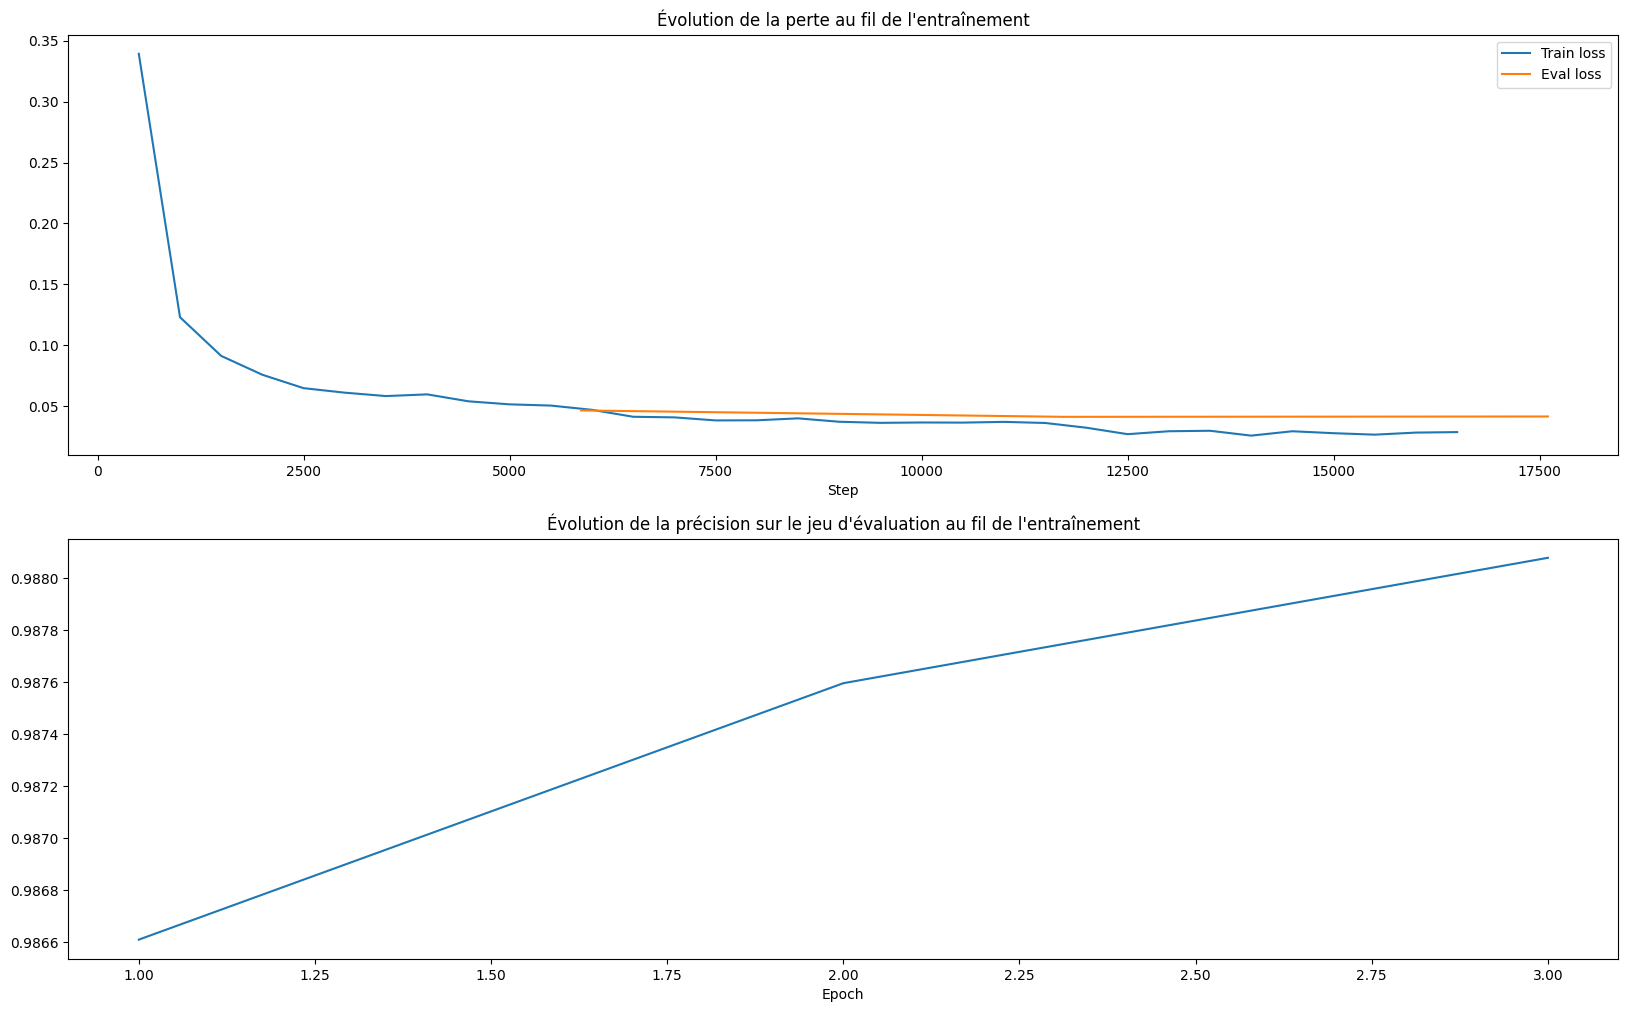

In [50]:
import matplotlib.pyplot as plt


plt.figure(figsize=(20, 12))

plt.subplot(2, 1, 1)
plt.plot(
    [train_log['step'] for train_log in train_logs],
    [train_log['loss'] for train_log in train_logs],
    label='Train loss'
)
plt.plot(
    [eval_log['step'] for eval_log in eval_logs],
    [eval_log['eval_loss'] for eval_log in eval_logs],
    label='Eval loss'
)
plt.xlabel('Step')
plt.legend()
plt.title("Évolution de la perte au fil de l'entraînement")

plt.subplot(2, 1, 2)
plt.plot(
    [eval_log['epoch'] for eval_log in eval_logs],
    [eval_log['eval_accuracy'] for eval_log in eval_logs],
)
plt.xlabel('Epoch')
plt.title("Évolution de la précision sur le jeu d'évaluation au fil de l'entraînement")

plt.show()

Le modèle est d'ores-et-déjà enregistré localement, mais nous allons également faire une sauvegarde sur *HuggingFace* pour pouvoir le récupérer plus tard depuis n'importe quel appareil :

In [52]:
trainer.push_to_hub()

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.98k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Clemnt73/RoBERTa-ner/commit/b80ebfacd6aa02415d68c00789a38126e58242ef', commit_message='End of training', commit_description='', oid='b80ebfacd6aa02415d68c00789a38126e58242ef', pr_url=None, pr_revision=None, pr_num=None)

### Conclusion
Notre modèle est désormais entraîné, testé et sauvegardé ! Il ne reste désormais plus qu'à le mettre en production dans notre système de RAG afin d'en apprécier la plus-value !